# STA 663 Final Project: Scalable k means++

Yingshi chen, Yixuan Wang

April 2018

## Abstract

K-means algorithm is a popular clustering analysis method. However, the performance of K-means algorithm is largely affected by the initialization. A better choice of intimal centroids would make the K-means algorithm work much better and converge in shorter time. In this paper, we implement the algorithm K-means ||, which also called scalable K-means. This algorithm was introduced by Bahmani, Moseley, et. al, in 2012. This algorithm provided another way to initialize the centroids, which is said to be more efficient selection of initial centroid.  In this paper, we tried different initialization, like random initialization, K-means plus plus and K-means ||, for the K-mean algorithm. We have tested their performance on various data sets, and optimized them with jit, vectorize and cython. A package of mentioned algorithm is created, uploaded and ready for installation.

## 1. Background

As an important topic in data management and data mining, clustering has been frequently studied. Among the hundreds of different algorithms that have been published on this topic, *k* **-means** is the most popular one because of its simplicity. The algorithm of *k* **-means** can be summarized as following: a set of random centers are chosen initially, each point is repeatedly assigned to its nearset center, and the centers are recalculated based on point assignments. The local search of centers is called *Lloyd's* iteration and stops only if solution does not change any more. However, *k* **-means** algorithm also has disadvantages. For example, although the final solution of *k* **-means** is locally optimal, it can be far away from the global optimum.

In order to improve k-means algorithm's efficiency, recent studies focused on obtaining a good starting point. One procedure called *k* **-means++** was developed; this algorithm only selects initial set of centers randomly, and each of the following centers is selected with a probability proportional to its contribution to the overall error given the previous selections. The initialization by *k* **-means++** can lead to an *O*(log *k*) approximation of the optimum. Although *k* **-means++** algorithm improves the efficiency of the original *k* **-means** algorithm, its sequential nature makes it unparallelizable.

Bahmani,Moseley, Vattani, Kumar, and Vassilvitskii, 2012 developed a parallel version of *k* **-means++** algorithm named *k* **-means++||**. Instead of sampling only one point in each round of the *k* **-means++** algorithm, *O*(log *k*) points are sampled and this process is repeated for roughly *O*(*k* log *n*). Then these *O*(*k* log *n*) point are reclustered into the \textit{k} initial centers for Lloyd's iteration. Doesn't like \textit{k}\textbf{-means++} algorithm, *k* **-means++||** initialization algorithm can be parallel implemented easily. After evaluating the performance of *k* **-means++||** on real-world data sets, Bahmani et al., 2012 found out that:

* The parallel implementation of *k* **-means++||** has much better performances than existing parallel algorithms for *k* **-means**.
* *k* **-means++||** has the smallest number of iterations until Lloyd's iteration stops.

In this paper, we will to implement *k* **-means++||** algorithm in python and test it on various data sets. We will examine the observations found by Bahmani et al, 2012. and find out any new facts about *k* **-means++||** as well.

## 2. Description of algorithm
### 2.1 Notation and background

#### 2.1.1 Notations
1. {X =  $\{x_1,...,x_n\}$} : a set of points in the *d* -dimensional Euclidean space
2. *k* : a positive integer standing for number of clusters
3. $\|x_i-x_j\|$ : Euclidean distance between $x_i$ and $x_j$
4. $d(x,Y) =  \min\limits_{y\in Y}\|x-y\|$ : the distance of a point x and a subset $Y\subseteq X$ of points 
5. centroid(*Y*) = $\frac{1}{|Y|}\sum\limits_{y\in Y}{y}$ : the centroid of a subset $Y\subseteq X$ of points 
6. $\phi_Y(C) = \sum\limits_{y\in Y}{d^2(y,C)} = \sum\limits_{y\in Y}\min\limits_{i=1,...,k}\|y-c_i\|^2$ : the cost of Y with respect of *C* for *C* = $\{c_1,...,c_k\}$} and $Y\subseteq X$ 

#### 2.1.2 K-means
In *k* **-means** clustering, we want to choose a set *C* of *k* centers that minimizes $\phi_X(C)$. We define $\phi^*$ as the cost of the optimal *k* **-means** clustering, and a set *C* of centers is an $alpha$ *-approximation* to *k* **-means** if $\phi_X(C) \leq \alpha\phi^*$.
As described in the above section, in *k* **-means** algorithm, a set of *k* centers is randomly selected at first. In each of the following iterations, a clustering of *X* is derived from current centers, and the centroids of the derived clusters becomes the centers for the next iteration. The iterations continues until centers does not change any more.

#### 2.1.3 K-means++
*k* **-means++** algorithm is similar to *k* **-means**, but has a different initialization step. Centers will be chosen one by one where the current set of chosen centers stochastically bias the choice of next center. The detailed initialization step can be described as following:
1. Choose one center uniformly at random from among the data points. This is the very first point in *C* ($c_1$).
2. For each $x \in X$ calculate *d*, which is the distance between x and the nearest center that has already been chosen.
3. One point $x \in X$ is randomly sampled with probability of $\frac{d^2(x,C)}{\phi_X(C)}$ as the next center. Add this center into *C*.
4. Step 2 and 3 are repeated until *k* centers have been chosen. We will have *k* centers as *C* = $\{c_1,...,c_k\}$}.

The initialization step of *k* **-means++** can obtain an (8log *k*)-approximation to $\phi^*$. However, due to its sequential nature, it cannot be parallelized.

### 2.2 K-means++|| algorithm
#### 2.2.1 Intuition
Traditional *k* **-means** algorithm randomly selects *k* centers in a single iteration according to the uniform distribution. *k* **-means++** algorithm, which is introduced later, selects one center each time for *k* iterations over a non-uniform distribution and this distribution is continually updated after selection of each new center. The goal of developers of  *k* **-means++** was to create an algorithm that selects more than one point at each iteration based on an non-uniform distribution and only requires small number of iterations.

#### 2.2.2. Algorithm explaintion
The *k* **-means||** differs from *k* **-means** because it uses an oversampling factor *l* = $\Omega(k)$}; *l* should be considered as $\Theta(k)$. The detailed steps of *k* **-means++||** is illstrated as following:

1. Choose one center uniformly at random from among the data points. This is the very first point in *C* ($c_1$).
2. Compute $\psi = \phi_X(C)$, the initial cost of the clustering after this selection.
3. One point $x \in X$ is randomly sampled with probability of $\frac{l\times d^2(x,C)}{\phi_X(C)}$ as the next center. Add this center into *C*.
4. Repeat the previous two steps for *O*(log $\psi$) times.
5. For $x \in C$, define $w_x$ as the number of points in *X* closer to x than any other point in *C*.
6. Recluster the weighted points in *C* into *k* clusters.

Theoretically, the expected number of points in *C* is *l*$\times$log($\psi$), and this number is typically more than *k*. In Step 5, weights are assigned to points in *C* and points are reclustered into *k* clusters. Reclustering can be done quickly because the size of *C* is much smaller than the size of the input data. It is also proved by Bahmani et al., 2012 that if an $\alpha$-approximation algorithm is used in the last step, then *k* **-means++||** can achieve a solution that is an *O*($\alpha$)-approximation to k-means.

## 3. Implementation
### 3.1 Naive version

### standard k means with random intialization 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%load_ext Cython

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
iris = iris.data[:, :4]
X = iris
k=3
l=2

In [3]:
def dist(a, b, ax=-1):
    # the distance function
    return np.linalg.norm(a - b, axis=ax)

In [4]:
#initialization select random centroids: 
def k_means_int(k,data,radom_state=42):
    """
    K-means random Initialization
    X: dataset
    k: number of clusters
    Returns:
    C: the centroids
    """
    X = data
    rng = np.random.RandomState(radom_state)
    i = rng.permutation(X.shape[0])[:k]
    C = X[i]
    return C

In [5]:
def k_means(k,X,C,max_iter=10000):
    """
    K-means algorithm
    X: dataset
    k: number of clusters
    C: the initial centroids
    max_iter: number of maximum iterations
    Returns:
    C: the final centers for each clusters
    clutser: the labels assiged to each data
    m: the number of iteration until converge
    """
    clusters = np.zeros(len(X))
    C_old = np.zeros(C.shape)
    error = dist(C, C_old, None)
    m=0
    while (error !=0):
        # update cluster groups
        for i in range(len(X)):
                distances = dist(X[i], C)
                cluster = np.argmin(distances)
                clusters[i] = cluster     
        # update the centroid 
        new_centers = np.array([X[clusters == i].mean(0)
                                for i in range(k)])
        
        # check convergence
        error = dist(C, C_old, None)
        C_old = C
        C= new_centers
        m+=1
        if m > max_iter:
            break
    return (C,clusters,m)

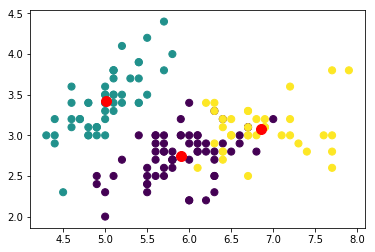

In [6]:
C1 =k_means_int(k,X)
centers, labels = k_means(3,X,C1)[:2]
plt.scatter(X[:,0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:,1], s = 100, c = 'red', label = 'Centroids')

### k means plusplus

In [7]:
def k_meanspp(k, X, random_state=42):
    """
    K-means plusplus Initialization
    X: dataset
    k: number of clusters
    random_state: the random seed 
    Returns:
    C: the centroids
    """
    # generate centers
    rs = np.random.RandomState(random_state)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    while C.shape[0] <= k-1:
 
        distances =np.array([min([dist(c,x,0) for c in C]) for x in X])
        #calculate the probability of centers
        prob = distances/distances.sum()
        cumprob = np.cumsum(prob)
        r = rs.random_sample()
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X[indice].reshape(1,X.shape[1])
        C = np.append(C,nc,axis=0)
    return C

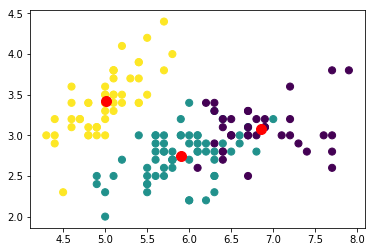

In [8]:
C2 = k_meanspp(k,X)
centers, labels = k_means(3,X,C2)[:2]
plt.scatter(X[:,0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:,1], s = 100, c = 'red', label = 'Centroids')

### scalable k means ||

In [9]:
def weights_c(X, C):
    """
    weights for each centroids
    X: dataset
    C: the centroids
    Returns:
    w: weights for each centroids
    """
    w = np.zeros(C.shape[0])
    for i in range(len(X)):
        if X[i] not in C:
            ind = np.argmin([dist(X[i],c,0) for c in C])
            w[ind] +=1
    return w

def weighted_kmeans(Cen,w,k,random_state=42):
    """
    weighted kmeans
    Cen: centroids 
    k: number of clusters
    w: the weight for each centers
    random_state: the random seed 
    Returns:
    C: the reduced centroids. Reducing the number centroids to k
    """
    rs = np.random.RandomState(random_state)
    ran = rs.randint(len(Cen))  
    C1 = Cen[ran,:].reshape(1,Cen.shape[1])
    X1 = np.delete(Cen, ran, 0)
    w= np.delete(w,ran)
    while C1.shape[0] <= k-1:
        #calculate the probability of centers
        prob =w/w.sum()
        cumprob = np.cumsum(prob)
        r = rs.random_sample()
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X1[indice].reshape(1,Cen.shape[1])
        X1 = np.delete(X1, indice, 0)
        w = np.delete(w, indice)
        C1 = np.append(C1,nc,axis=0)
    return C1

def k_meansll(k, X,l, random_state = 42):
    """
    K-means|| Initialization
    X: dataset
    k: number of clusters
    random_state: the random seed 
    l: the oversample factor 
    Returns:
    C: the centroids
    """
    #step 1 random centroid
    rs = np.random.RandomState(random_state)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    distances =np.array([min([dist(c,x,0) for c in C]) for x in X])
    phi = distances.sum()
    lgphi = round(np.log(phi))
    prob = l*distances/distances.sum()
    cumprob = np.cumsum(prob)
    i=0 
    while i < lgphi:
            r = rs.uniform(0,l,1)
            #get the indice for the next cnter
            indice = min(np.where(cumprob >= r))[0]
            nc = X[indice].reshape(1,X.shape[1])
            C = np.append(C,nc,axis=0)
            i+=1
    w = weights_c(X,C) 
    w_C = weighted_kmeans(C,w,k) 
    return w_C

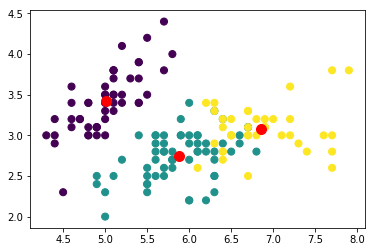

In [10]:
C3 = k_meansll(k,X,l)
centers, labels = k_means(3,X,C3)[:2]
plt.scatter(X[:,0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:,1], s = 100, c = 'red', label = 'Centroids')

### optimize the k_means_int_v

### jit

In [11]:
from numba import jit, float64, int64

In [12]:
import numpy as np
@jit('float64[:,:](int64, float64[:,:], int64)')
def k_means_int_j(k,data,radom_state=42):
     #initialization select random centroids:     
    X = data
    rng = np.random.RandomState(radom_state)
    i = rng.permutation(X.shape[0])[:k]
    C = X[i]
    return C

### vectorization

In [13]:
from numba import jit, float64, int64, int32, vectorize,float32
import numba
@numba.guvectorize([(float64[:,:], int64, float64[:,:])], '(nx,ny),()->(nx,ny)')
def k_means_int_v(data,k,res):
     #initialization select random centroids:   
    nx,ny =data.shape
    X = data
    rng = np.random.RandomState(42)
    i = rng.permutation(X.shape[0])[:k]
    res = X[i]

### Cython

In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [15]:
%%cython -a
import numpy as np

def k_means_int_cython(k,data,radom_state=42):
     #initialization select random centroids:     
    X = data
    rng = np.random.RandomState(radom_state)
    i = rng.permutation(X.shape[0])[:k]
    C = X[i]
    return C

In [16]:
%timeit k_means_int(3,X)

20.2 µs ± 389 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit k_means_int_j(3,X)

123 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit k_means_int_v(X,3)

35 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit k_means_int_cython(3,X)

20.2 µs ± 238 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


So from the above results we can see that, the k_means_int function could not be optimized by jit, vectorize and cython

### optimize the k_means_function

### jit 

In [20]:
import numba as nb
import numpy as np
import operator
@jit
def k_means_j(k,X,C,max_iter=10000):
    clusters = np.zeros(len(X))
    X_view = X
    C_old = np.zeros(C.shape)
    error = dist(C, C_old, None)
    distances = distances = np.zeros([C.shape[0]])
    new_centers = np.zeros((k,X.shape[1]))
    m=0
    while (error !=0):
        # update cluster groups        
        for i in range(X.shape[0]):
                for n in range(C.shape[0]):
                    norm = 0
                    for a in range(C.shape[1]):
                        norm += (X_view[i,a]-C[n,a])**2
                    distances[n] = np.sqrt(norm)
                cluster = np.argmin(distances)
                clusters[i] = cluster    
        # update the centroid 
        for i in range(k):           
            new_centers[i,:] = np.mean(X[clusters == i], axis=0 )  
        # check convergence
        error = dist(C, C_old, None)
        C_old = C
        C= new_centers
        m+=1
        if m > max_iter:
            break
    return C,clusters,m

### vectorize

In [21]:
import numba as nb
import numpy as np
import operator
@numba.guvectorize([(int64,float64[:,:],  float64[:,:],int64, float64[:,:])], '(),(nx,ny),(z,ny),()->(nx,ny)')
def k_means_v(k,X,C,max_iter,res):
    nx,ny = X.shape
    z,ny = C.shape
    clusters = np.zeros(len(X))
    X_view = X
    C_old = np.zeros(C.shape)
    error = dist(C, C_old, None)
    distances = distances = np.zeros([C.shape[0]])
    new_centers = np.zeros((k,X.shape[1]))
    m=0
    while (error !=0):
        # update cluster groups        
        for i in range(X.shape[0]):
                for n in range(C.shape[0]):
                    norm = 0
                    for a in range(C.shape[1]):
                        norm += (X_view[i,a]-C[n,a])**2
                    distances[n] = np.sqrt(norm)
                cluster = np.argmin(distances)
                clusters[i] = cluster    
        # update the centroid 
        for i in range(k):           
            new_centers[i,:] = np.mean(X[clusters == i], axis=0 )  
        # check convergence
        error = dist(C, C_old, None)
        C_old = C
        C= new_centers
        m+=1
        if m > max_iter:
            break
        res = clusters

### cython

In [22]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
DTYPE = np.float
ctypedef np.float_t DTYPE_t
cdef extern from "math.h":
    double sqrt(double)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def k_means_cython(int k, np.ndarray[double, ndim=2] X, np.ndarray[double, ndim=2] C, int max_iter=10000):
    cdef double[:,:] X_view = X
    cdef np.ndarray[double, ndim=1] clusters = np.zeros([X.shape[0]])
    cdef np.ndarray[double, ndim=2] C_old = np.zeros([C.shape[0],C.shape[1]])
    cdef double[:,:] C_view = C
    cdef double[:,:] C_old_view = C_old
    cdef double error = np.linalg.norm(C - C_old)
    cdef int m = 0
    cdef np.ndarray[double, ndim=1] distances = np.zeros([C.shape[0]])
    cdef int cluster = 0
    cdef np.ndarray[double, ndim=2] new_centers = np.zeros([k,X.shape[0]])
    cdef int i,j,n,a
    cdef double norm = 0
    while error != 0:
        # update cluster groups
        for i in range(X.shape[0]):
                for n in range(C.shape[0]):
                    norm = 0
                    for a in range(C.shape[1]):
                        norm += (X_view[i,a]-C[n,a])**2
                    distances[n] = sqrt(norm)
                cluster = np.argmin(distances)
                clusters[i] = cluster
        
        # update the centroid 
        new_centers = np.array([X[clusters == i].mean(0) for i in range(k)])
        
        # check convergence
        norm = 0
        error = np.linalg.norm(C - C_old)
        C_old = C
        C= new_centers
        m += 1
        if m > max_iter:
            break
    return (C, clusters, m)

In [23]:
k=3
C1 =k_means_int(k,X) 
%timeit k_means(3,X,C1)

17.5 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
C1 =k_means_int(k,X)
%timeit k_means_j(3,X,C1,10000)

11.2 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
C1 =k_means_int(k,X)
%timeit k_means_v(3,X,C1,10000)

10.3 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
C1 =k_means_int(k,X) 
%timeit k_means_cython(3,X,C1)

2.44 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From the above results we can see cython could optimize the k_means function a lot. With cython, the k means function is nearly 6 times faster. Jit and vectorize could also improve the k_means function

### optimize k means plusplus

### jit

In [27]:
import numpy as np
@jit('float64[:,:](int64, float64[:,:], int64)')
def k_meanspp_j(k, X, random_state=42):
    # generate centers
    rs = np.random.RandomState(random_state)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    while C.shape[0] <= k-1:
        distances=[]
        for x in X:
            dis = []           
            for c in C:
                d = dist(c,x,-1)
                dis.append(d)
            dd = min(dis)
            distances.append(dd)
        #calculate the probability of centers
        prob = distances/sum(distances)
        cumprob = np.cumsum(prob)
        r = np.random.random_sample()
        #get the indice for the next cnter
        indice = np.argmin(np.where(cumprob >= r))
        nc = X[indice].reshape(1,X.shape[1])
        C = np.append(C,nc,axis=0)
    return C

### vectorize

In [28]:
import numba
@numba.guvectorize([(float64[:,:], int64, float64[:,:])], '(nx,ny),()->(nx,ny)')
def k_meanspp_v(X,k, res):
    # generate centers
    nx,ny = X.shape
    np.random.seed(42)   
    rs = np.random.RandomState(42)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
#     while len(C) <= k-1:
    while C.shape[0] <= k-1:
        #calculate the distance to the nearest center
#         if len(C) ==1:
        distances=[]
        for x in X:
            dis = []           
            for c in C:
                d = dist(c,x,-1)
                dis.append(d)
            dd = min(dis)
            distances.append(dd)
        #calculate the probability of centers
        prob = distances/sum(distances)
        cumprob = np.cumsum(prob)
        r = np.random.random_sample()
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X[indice].reshape(1,X.shape[1])
        C = np.append(C,nc,axis=0)
    res= C

### cython

In [29]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
DTYPE = np.float
ctypedef np.float_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def kmeanspp_cython(int k, np.ndarray[double, ndim=2] X, int random_state=42):
    # generate centers
    rs = np.random.RandomState(random_state)
    cdef np.ndarray[double, ndim=2] C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    cdef np.ndarray[double, ndim=2] nc = np.zeros([1,X.shape[1]])
    cdef np.ndarray[double, ndim=1] distances = np.zeros([X.shape[0]])
    cdef np.ndarray[double, ndim=1] prob = np.zeros([X.shape[0]])
    cdef np.ndarray[double, ndim=1] cumprob = np.zeros([X.shape[0]])
    cdef int indices
    while C.shape[0] <= k-1:
        #calculate the distance to the nearest center
        distances = np.array([min([np.linalg.norm(c - x) for c in C]) for x in X])
        
        #calculate the probability of centers
        prob = distances/distances.sum()
        cumprob = np.cumsum(prob)
        r = rs.random_sample()
        
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X[indice].reshape(1,X.shape[1])
        C = np.append(C,nc,axis=0)
    return C

In [30]:
%timeit k_meanspp(3, X)

6.64 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%timeit k_meanspp_j(3, X)

7.05 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit k_meanspp_v(X, 3)

6.95 ms ± 58.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit kmeanspp_cython(3, X)

3.9 ms ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From the above results we can see only cython could optimize the k means plusplus function. 

### optimize k means ||

### jit

In [44]:
import numpy as np

def weights_c(X, C):
    w = np.zeros(C.shape[0])
    for i in range(len(X)):
        if X[i] not in C:
            ind = np.argmin([dist(X[i],c,0) for c in C])
            w[ind] +=1
    return w

def weighted_kmeans(Cen,w,k,random_state=42):
    rs = np.random.RandomState(random_state)
    ran = rs.randint(len(Cen))  
    C1 = Cen[ran,:].reshape(1,Cen.shape[1])
    X1 = np.delete(Cen, ran, 0)
    w= np.delete(w,ran)
    while C1.shape[0] <= k-1:
        #calculate the probability of centers
        prob =w/w.sum()
        cumprob = np.cumsum(prob)
        r = rs.random_sample()
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X1[indice].reshape(1,Cen.shape[1])
        X1 = np.delete(X1, indice, 0)
        w = np.delete(w, indice)
        C1 = np.append(C1,nc,axis=0)
    return C1

@jit
def k_meansll_j(k, X,l, random_state = 42):
    #step 1 random centroid
    rs = np.random.RandomState(random_state)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    distances=[]
    prob = np.zeros(len(X))
    for x in X:
        dis = []           
        for c in C:
            d = dist(c,x,-1)
            dis.append(d)
        dd = min(dis)
        distances.append(dd)
    phi = sum(distances)
    lgphi = round(np.log(phi))
    for d in range(len(distances)):
        prob[d] = (distances[d]*l)/phi
    cumprob = np.cumsum(prob)
    i=0   
    while i < lgphi:
            r = np.random.uniform(0,l,1)
            indice = min(np.where(cumprob >= r))[0]
            nc = X[indice].reshape(1,X.shape[1])
            C = np.append(C,nc,axis=0)
            
            i+=1
    w = weights_c(X,C) 
    w_C = weighted_kmeans(C,w,k) 
    return w_C

### vectorize

In [45]:
import numpy as np
@numba.guvectorize([(int64,float64[:,:], int64,int64, float64[:,:])], \
                   '(),(nx,ny),(),()->(nx,ny)')
def k_meansll_v(k, X,l, random_state, res):
    #step 1 random centroid
    rs = np.random.RandomState(random_state)
    C = X[rs.randint(len(X)),:].reshape(1,X.shape[1])
    prob = np.zeros(len(X))
    distances=[]
    for x in X:
        dis = []           
        for c in C:
            d = dist(c,x,-1)
            dis.append(d)
        dd = min(dis)
        distances.append(dd*l)
    phi = sum(distances)
    lgphi = round(np.log(phi))
    for d in range(len(distances)):
        prob[d] = (distances[d]*l)/phi     
    cumprob = np.cumsum(prob)
    i=0  
    while i < lgphi:
            r = np.random.uniform(0,l,1)
            #get the indice for the next cnter
            indice = min(np.where(cumprob >= r))[0]
            nc = X[indice].reshape(1,X.shape[1])      
            C = np.append(C,nc,axis=0)
            i+=1
    w = weights_c(X,C) 
    w_C = weighted_kmeans(C,w,k) 
    res =  w_C

### Cython

In [36]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
DTYPE = np.float
ctypedef np.float_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def weights_c_cython(np.ndarray[double, ndim=2] X, np.ndarray[double, ndim=2] C):
    cdef np.ndarray[double, ndim=1] w = np.zeros([C.shape[0]])
    cdef int i, ind
    for i in range(X.shape[0]):
        if X[i] not in C:
            ind = np.argmin([np.linalg.norm(X[i]-c) for c in C])
            w[ind] +=1
    return w

def weighted_kmeans_cython(np.ndarray[double, ndim=2] Cen, np.ndarray[double, ndim=1] w, int k, int random_state=42):
    rs = np.random.RandomState(42)
    cdef int ran = rs.randint(len(Cen))    
    cdef np.ndarray[double, ndim=2] C1 = Cen[ran,:].reshape(1,Cen.shape[1])
    cdef np.ndarray[double, ndim=2] X1 = np.delete(Cen, ran, 0)
    w = np.delete(w, ran)
    cdef np.ndarray[double, ndim=1] prob = w/w.sum()
    cdef np.ndarray[double, ndim=1] cumprob = np.cumsum(prob)
    cdef np.ndarray[double, ndim=2] nc = np.zeros([1,Cen.shape[1]])
    cdef int r = 0
    cdef int indice
    while C1.shape[0] <= k-1:
        #calculate the probability of centers
        prob =w/w.sum()
        cumprob = np.cumsum(prob)
        r = rs.random_sample()
        #get the indice for the next cnter
        indice = min(np.where(cumprob >= r))[0]
        nc = X1[indice].reshape(1,Cen.shape[1])
        X1 = np.delete(X1, indice, 0)
        w = w[w!=w[indice]]
        C1 = np.append(C1,nc,axis=0)
    return C1
    

def k_meansll_cython(int k, np.ndarray[double, ndim=2] X, int l, int random_state = 42):
    #step 1 random centroid
    rs = np.random.RandomState(random_state)
    cdef np.ndarray[double, ndim=2] C = X[rs.randint(X.shape[0]),:].reshape(1,X.shape[1])
    cdef np.ndarray[double, ndim=1] distances =np.array([min([np.linalg.norm(c - x) for c in C]) for x in X])
    cdef double phi = distances.sum()
    cdef double lgphi = round(np.log(phi))
    cdef np.ndarray[double, ndim=1] prob = l*distances/distances.sum()
    cdef np.ndarray[double, ndim=1] cumprob = np.cumsum(prob)
    cdef np.ndarray[double, ndim=2] nc = np.zeros([1,X.shape[1]])
    cdef int i=0
    cdef int indice
    cdef double r
    while i < lgphi:
            r = rs.uniform(0,l,1)
            #get the indice for the next cnter
            indice = min(np.where(cumprob >= r)[0])
            nc = X[indice].reshape(1,X.shape[1])
            C = np.append(C,nc,axis=0)
            i+=1
    w = weights_c_cython(X,C) 
    w_C = weighted_kmeans_cython(C,w,3) 
    return w_C

In [37]:
%timeit k_meansll(3,X,2)

9.34 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%timeit k_meansll_j(3,X,2,42)

13.7 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit k_meansll_v(3,X,2,42)

14.7 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%timeit k_meansll_cython(3,X,2)

6.44 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


From above results we can see only cythin could optimize the k means || function

In general, cython works the best for optimzing functions in our cases. It performs extraordinary well in optimizing the k means function

## Testing 

### test the dist_fucntIon
* for the distance function, we test the non-negativity, symmetry, and zero-norm property

In [48]:
import numpy as np
a = np.random.normal((3,4))
b = np.random.normal((5,4))
print(dist(a,b,-1))
#test for non-negativity
assert dist(a,b,-1) >=0, "fail non-negative test"
# test for symmetry
assert dist(a,b,-1) == dist(b,a,-1), "fail symmetry test"
# test for dist = 0, if and only if it is the same vector
assert (dist(a,b) ==0).all()
#test dist = 0. if and only iff a = b
assert (dist(a,a) ==0).all()
# test for dist !=0, when a !=b
assert (dist(a,b) !=0).any()  
#test whether the dist return the desired number 
from scipy.spatial import distance
assert (dist(a,b) == distance.euclidean(a,b)), "fail the test"

4.85249509380338


AssertionError: 

From the above test, we can see the distance function could produce the correct euclidean distance between points and meets all the properties.

### test k_means with iris data with random initialization
* check the function could produce exact k cluster
* check the length of label output has the same length as the data
* check the number of centers equals to k

In [49]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, :4] 
k=3
C = k_means_int(k,X)
center, cluster = k_means(k,X,C)[:2]
#check the k_means has exact k cluster
assert len(np.unique(cluster))==k, "fail the k cluster test"
#check the length of label == len of data
assert len(cluster) == len(X), "fail the length of data test"
#check the number of centers == k
assert center.shape[0] == k, "fail the center number test"

### test the k_means ++, keans|| and k_means_int
* test whethere all those function could produce desired output 

In [50]:
#test the output centroid shape
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, :4] 
k=3
l=2
C1 =k_means_int(k,X) 
C2 = k_meanspp(k,X)
C3 = k_meansll(k,X,l)
assert (C1.shape) == (k, X.shape[1]),"fail"
assert (C2.shape) == (k, X.shape[1]),"fail"
assert (C3.shape) == (k, X.shape[1]),"fail"

## 4. Evaluation on data sets
### 4.1 Dataset discription
#### 4.1.1 Simulated data

The first dataset is the simulated Gaussian Mixture dataset that is described in the paper by Bahmani et al, 2012. We  first sample *k* centers from a 15 dimensional Gaussian distribution with mean at zero and a specified variance. Then we sample 10,000 from Guassian distributions with unit variance centereted around each *k* center. This is a mixture of *k* Gaussians with equal weights.

In [51]:
mean_vector = np.zeros(15)
cov_matrix = np.eye(15)*2
samples = np.random.multivariate_normal(mean_vector,cov_matrix,20)

In [52]:
S = 10000
data = []
true_class = []
for i in range(20):
    mean = samples[i]
    data1 = np.random.multivariate_normal(mean, np.diag(np.ones(15)), int(S/20))
    labels = np.repeat(i, int(S/20))
    
    data.append(data1)
    true_class.append(labels)

In [53]:
simu_data = np.vstack(data)
simu_class = np.vstack(true_class)

#### 4.1.2 Real-world data
We use the SPAM data set described in the paper by Bahmani et al, 2012. This dataset consists of 4601 points in 58 di- mensions and represents features available to an e-mail spam detection system. We also use the IRIS data set in the same directory as the SPAM data. This data contains 150 observations of irises from 3 different species. There are four features: sepal width, sepal length, petal width, and petal length. We used the IRIS data to test whether the orginal functions work as they should do. We also used this data set directly after optimization functions were created, in order to test how efficient optimization functions were. Results can be seeked in previous sections.

In [54]:
import urllib
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
# download the file
raw_data = urllib.request.urlopen(url)
spam = np.loadtxt(raw_data, delimiter=",")

#### 4.1.3 toy data
In order to make sure that our functions work proporly, we set up a group of toy data that we know the true centers. We then plot the predicted centers from *k* **-means++** and *k* **-means++||** functions. It looks like that the functions did a good job on prediction.

In [55]:
np.random.seed(42)
mean1=[0,0]
cov1=np.array([[1, 0], [0, 1]])
sample1 = np.random.multivariate_normal(mean1, cov1, 200)

mean2=[12,12]
cov2=np.array([[1, 0], [0, 1]])
sample2 = np.random.multivariate_normal(mean2, cov2, 200)

mean3=[8,8]
cov3=np.array([[1, 0], [0, 1]])
sample3 = np.random.multivariate_normal(mean3, cov3, 200)

mean4=[5,5]
cov4=np.array([[1, 0],[0, 1]])
sample4 = np.random.multivariate_normal(mean4, cov4, 200)

In [56]:
sample=np.vstack((sample1,sample2,sample3,sample4))
true_cen=np.vstack((mean1,mean2,mean3,mean4))
C1=k_meanspp(4,sample)
pred_cen1=np.array(k_means(4,sample,C1)[0])

(-2, 15)

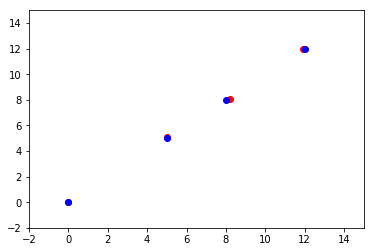

In [57]:
plt.figure()
plt.plot(pred_cen1[:,0],pred_cen1[:,1],"ro")
plt.plot(true_cen[:,0],true_cen[:,1],"ro",color="blue")
plt.xlim(-2,15)
plt.ylim(-2,15)

(-2, 15)

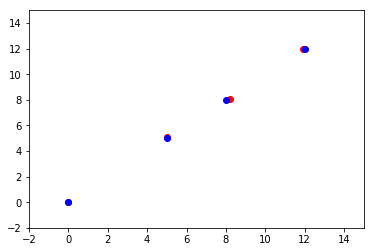

In [79]:
C2=k_meansll(4,sample,2)
predict_center2=np.array(k_means(4,sample,C2)[0])

plt.figure()
plt.plot(pred_cen1[:,0],pred_cen1[:,1],"ro")
plt.plot(true_cen[:,0],true_cen[:,1],"ro",color="blue")
plt.xlim(-2,15)
plt.ylim(-2,15)

### 4.2 Testing
#### 4.2.1 compare the iterations 
We want to evaluate the number of iterations needed to reach convergence for different initial centroids. 

* first test on the iris data set

In [60]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, :4] 
k=3
l=2
C1 =k_means_int(k,X) 
C2 = k_meanspp(k,X)
C3 = k_meansll(k,X,l)
[k_means(3,X,C1)[2],k_means(3,X,C2)[2] ,k_means(3,X,C3)[2]]

[7, 4, 8]

we can see on the iris data set, k means plusplus performs the best, which take the smallest number of iterations to meet convergence

* test on simualtion

In [62]:
C1 =k_means_int(10,simu_data) 
C2 = k_meanspp(10,simu_data)
C3 = k_meansll(10,simu_data,9)
[k_means(10,simu_data,C1)[2],k_means(10,simu_data,C2)[2] ,k_means(10,simu_data,C3)[2]]

[105, 43, 30]

we can see that on the simulated data set, k means plusplus and k means || perform better than random initial centers, which meet the conclusion from the paper

#### 4.2.2 Testing running time
we want to evaluate the running time of different functions. We want to examine the running time for initialization functions as well as the whole time takes to process k-means. We report the two options of running time for the original, JIT, Vectorize and Cython functions for all datasets. From the results, we can see that *k* **-means++||** is the fastest initialization method. We found out that among all the optimization methods, Cython is the best one. JIT and Vectorization have roughly the same speed as the orginal functions.

#### Test for initialization functions

In [58]:
import time
import pandas as pd

def timer(function, *args):
    startTime = time.time()
    result = function(*args)

    return time.time() - startTime

In [59]:
pd.DataFrame([[timer(k_means_int, 10, simu_data),timer(k_meanspp, 10, simu_data),
               timer(k_meansll, 10, simu_data, 9)],
              [timer(k_means_int_j, 10, simu_data),timer(k_meanspp_j, 10, simu_data),
               timer(k_meansll_j, 10, simu_data, 9)],
              [timer(k_means_int_v, simu_data, 10),timer(k_meanspp_v, simu_data, 10),
               timer(k_meansll_v, 10, simu_data, 9, 42)],
             [timer(k_means_int_cython, 10, simu_data),timer(kmeanspp_cython, 10, simu_data),
               timer(k_meansll_cython, 10, simu_data, 9)]], 
             index = ["Original","JIT","Vectorize","Cython"],
             columns = ["k_means","k-means++","k-means||"])

,k_means,k-means++,k-means||
Original,0.000851,5.055685,1.882524
JIT,0.000523,5.421164,1.864111
Vectorize,0.000312,5.477998,2.122445
Cython,0.000256,3.026814,1.192220


In [65]:
pd.DataFrame([[timer(k_means_int, 3, spam),timer(k_meanspp, 3, spam),
               timer(k_meansll, 3, spam, 2)],
              [timer(k_means_int_j, 3, spam),timer(k_meanspp_j, 3, spam),
               timer(k_meansll_j, 3, spam, 2)],
              [timer(k_means_int_v, spam, 3),timer(k_meanspp_v, spam, 3),
               timer(k_meansll_v, 3, spam, 2, 42)],
             [timer(k_means_int_cython, 3, spam),timer(kmeanspp_cython, 3, spam),
               timer(k_meansll_cython, 3, spam, 2)]], 
             index = ["Original","JIT","Vectorize","Cython"],
             columns = ["k_means","k-means++","k-means||"])

,k_means,k-means++,k-means||
Original,0.000215,0.183429,0.899232
JIT,0.000386,0.189276,0.914750
Vectorize,0.000248,0.188952,0.963410
Cython,0.000160,0.110478,0.005955


we experiment with different *l* values to see how they affect performance. We try 3 differnt values and reported their running time on different *k* **-means++||** functions, there are no obvious differences between different *l*s.

In [67]:
pd.DataFrame([[timer(k_meansll, 10, simu_data, 1), timer(k_meansll_j, 10, simu_data, 1),
              timer(k_meansll_v, 10, simu_data, 1, 42),
               timer(k_meansll_cython, 10, simu_data, 1)],
             [timer(k_meansll, 10, simu_data, 2), timer(k_meansll_j, 10, simu_data, 2),
              timer(k_meansll_v, 10, simu_data, 2, 42),
               timer(k_meansll_cython, 10, simu_data, 2)],
             [timer(k_meansll, 10, simu_data, 8), timer(k_meansll_j, 10, simu_data, 8),
              timer(k_meansll_v, 10, simu_data, 8, 42),
               timer(k_meansll_cython, 10, simu_data, 8)]], 
             index = ["l*0.5","l","l*4"],
             columns = ["original","JIT","Vectorize","Cython"])

,original,JIT,Vectorize,Cython
l*0.5,1.838064,1.879462,1.946716,1.216089
l,1.936132,1.943318,2.013687,1.201647
l*4,2.009786,1.891337,2.195628,1.213872


## 5. Comparative analysis with competing algorithms

We compared our function of *k* **-means** with initialization of *k* **-means++** and *k* **-means++||** the build in *k* **-means** function with *k* **-means++** initialization and Hierarchical Clustering. The competing algorithms were designed to optimize the initialization speed, thus, we want to comparing the speed of three algorithms. From the result, we can see that our *k* **-means** function *k* **-means++** and *k* **-means++||** work better than the sklearn *k* **-means** function on the IRIS data. However, both our *k* **-means** function *k* **-means++** and *k* **-means++||** work slower than the competing algorithms, suggesting that there are still room for us to improve our initialization functions.

In [17]:
from sklearn import cluster
from scipy.cluster.hierarchy import fcluster,linkage
import pandas as pd

ir = linkage(X, method='single', metric='euclidean')
si = linkage(simu_data, method='single', metric='euclidean')
C1_1 = k_meanspp(10, simu_data)
C1_2 = k_meansll(10, simu_data, 9)
C2_1 = k_meanspp(3, X)
C2_2 = k_meansll(3, X, 2)

pd.DataFrame([[timer(cluster.k_means, simu_data, 10), timer(fcluster, si, 10),
               timer(k_means, 10, simu_data, C1_1), timer(k_means, 10, simu_data, C1_2)],
             [timer(cluster.k_means, ir, 3), timer(fcluster, ir, 3),
               timer(k_means, 3, X, C2_1), timer(k_means, 3, X, C2_2)]],
             index = ["simulated data","IRIS data"],
             columns = ["sklearn k-means++","hierarchical clustering", 
                        "k-means++","k-means++||"])

,sklearn k-means++,hierarchical clustering,k-means++,k-means++||
simulated data,0.814600,0.112222,4.119302,3.796680
IRIS data,0.027847,0.000821,0.010607,0.021616


## 6. Packaging

We packed our functions in a pacakge called **sta663yw261**. This package can be downloaded easily be *pip install* command. A detailed helping file will be uploaded in thr repository as well.

## 7. Discussion/conclusion
In this paper, we did the implementation of *k* **-means++** and *k* **-means++||** algorithms mentioned in paper  *Scalable K-Means++*, by Bahmani et al. (2012) to enhance the accuracy as well as the speed of the initialization steps of *k* **-means** clustering methods in python. On the top of writing the algorithms into python functions, we also did optimization of the orginal functions using JIT, vectorization and Cython. 

We applied our written functions into simulated data as well as real-world data, and compared the running time of initialization algorithms. From the result in test section before, we can see that *k* **-means++||** did a better job than *k* **-means++**; this result matches what discussed in the paper. Among all the approaches of optimization, we found out that Cython is the most efficient one. We also evaluated whether the choice of different oversampling parameters in *k* **-means++||** algorithm could lead to any changes, but we did not observe any obvious differences. 

We also campared our functions to existing python functions that address the same topic(clustering). We used build in *k* **-means** function with *k* **-means++** initialization and Hierarchical Clustering function to compare with our functions. Our functions were the slowest, indicating that there are still room for improvement.

The *k* **-means++** and *k* **-means++||** generally have better performance as initialization process for *k* **-means** clustering than random selection initialization. In our paper, we found out that *k* **-means++||** runs better job than *k* **-means++**. However, the test data sets we used are relatively small and we did not have any chance/time to apply our to a larger data set. In the future, our functions should be tested on larger data sets to see performance as well.

In the paper, one key feature *k* **-means++||** algorithm is that unlike *k* **-means++||**, it is parallelable. However, we did not have chance to reproduce the parallel implementation mentioned in the paper by MapReduce. In the future(if we have chance/time), we want to explore parallel implementations of *k* **-means++||** algorithm not only using MapReduce but also using other parallel implementation approahces.

## 8. Reference
1. Bahmani, B., Moseley, B., et al. (2012) "Scalable k-means++." Proceedings of the VLDB Endowment 5.7: 622-633.
2. Hees, J. (2015) SciPy Hierarchical Clustering and Dendrogram Tutorial https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
3. sklearn.cluster.k_means. http://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html